# DanQ CNN-LSTM Experiments
Based on the DanQ neural network for DNA classification (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4914104/), these are a series of experiments designed to test what is the optimum architecture for our given problem of DNA promoter classification given limited data, while still remaining relatively true to the general concept of the DanQ CNN-LSTM. Parameters we examine are stride of pooling, convolution kernel size, type of convolution used, and number of convolutional layers. 

In [1]:
# imports
from keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Dense, Dropout, Activation, AveragePooling1D, Bidirectional, MaxPooling2D, GaussianNoise
from keras.layers import Input, Concatenate, Flatten, Embedding, CuDNNLSTM, Conv1D, MaxPooling1D, LSTM, StackedRNNCells, LSTMCell, Reshape, TimeDistributed, SeparableConv1D
from keras.layers import RepeatVector, Permute, merge, multiply, GlobalMaxPooling1D, Lambda, BatchNormalization, GlobalAveragePooling1D
from keras.layers.merge import Multiply
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras import backend as K
import numpy as np
import os

c:\users\wolfgang\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
K.clear_session()
del model

In [6]:
# our data
start_target_size = (672, 4)
batch_size = 16
x_train = np.load('D:/Projects/iSynPro/iSynPro/DanQCNNLSTM/x_train.npy')
y_train = np.load('D:/Projects/iSynPro/iSynPro/DanQCNNLSTM/y_train.npy')

In [8]:
# Basic 1D Conv CNN LSTM
# ala DanQ
# this is our base case

# build our model
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
x = Conv1D(512, kernel_size=26, strides=1, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=13, strides=13)(x)
x = Dropout(0.2)(x)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/danq_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

Train on 16708 samples, validate on 1857 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.68549, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/danq_weights\weights-01-0.69.hdf5
 - 44s - loss: 0.6872 - binary_accuracy: 0.5452 - val_loss: 0.6855 - val_binary_accuracy: 0.5477
Epoch 2/30

Epoch 00002: val_loss improved from 0.68549 to 0.63686, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/danq_weights\weights-02-0.64.hdf5
 - 42s - loss: 0.6606 - binary_accuracy: 0.6047 - val_loss: 0.6369 - val_binary_accuracy: 0.6440
Epoch 3/30

Epoch 00003: val_loss improved from 0.63686 to 0.58992, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/danq_weights\weights-03-0.59.hdf5
 - 41s - loss: 0.6146 - binary_accuracy: 0.6612 - val_loss: 0.5899 - val_binary_accuracy: 0.6807
Epoch 4/30

Epoch 00004: val_loss improved from 0.58992 to 0.58494, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/danq_weights\weights-04-0.58.h

# Notes about kernel size and pool size
It doesn't necessarily make sense to be using such large kernel and pool sizes. Most transcription factors bind to DNA sites that are between 8 and 16 nucleotides long. Even these sites tend to have smaller pockets within them where the transcription factor actually binds with a high affinity. At the risk of having more parameters, we can test whether a finer grained architecture helps. 

In [9]:
# similar to DanQ as above
# but with different pool and kernel sizes
# and dropout schema

# build our model
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
x = Conv1D(256, kernel_size=16, strides=1, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=8, strides=8)(x)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallkerneldanq_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

Train on 16708 samples, validate on 1857 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.68160, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallkerneldanq_weights\weights-01-0.68.hdf5
 - 72s - loss: 0.6905 - binary_accuracy: 0.5307 - val_loss: 0.6816 - val_binary_accuracy: 0.5530
Epoch 2/30

Epoch 00002: val_loss improved from 0.68160 to 0.65363, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallkerneldanq_weights\weights-02-0.65.hdf5
 - 75s - loss: 0.6713 - binary_accuracy: 0.5900 - val_loss: 0.6536 - val_binary_accuracy: 0.6204
Epoch 3/30

Epoch 00003: val_loss improved from 0.65363 to 0.61188, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallkerneldanq_weights\weights-03-0.61.hdf5
 - 73s - loss: 0.6336 - binary_accuracy: 0.6414 - val_loss: 0.6119 - val_binary_accuracy: 0.6699
Epoch 4/30

Epoch 00004: val_loss improved from 0.61188 to 0.59965, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLS

In [3]:
# similar to DanQ as above
# but with different pool and kernel sizes
# and dropout schema

# build our model
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
x = Conv1D(256, kernel_size=16, strides=1, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=8, strides=2)(x)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallstridedanq_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

Train on 16708 samples, validate on 1857 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.62570, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallstridedanq_weights\weights-01-0.63.hdf5
 - 186s - loss: 0.6705 - binary_accuracy: 0.5849 - val_loss: 0.6257 - val_binary_accuracy: 0.6268
Epoch 2/30

Epoch 00002: val_loss improved from 0.62570 to 0.58325, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallstridedanq_weights\weights-02-0.58.hdf5
 - 181s - loss: 0.5982 - binary_accuracy: 0.6714 - val_loss: 0.5833 - val_binary_accuracy: 0.6909
Epoch 3/30

Epoch 00003: val_loss improved from 0.58325 to 0.56045, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallstridedanq_weights\weights-03-0.56.hdf5
 - 181s - loss: 0.5714 - binary_accuracy: 0.6962 - val_loss: 0.5605 - val_binary_accuracy: 0.7065
Epoch 4/30

Epoch 00004: val_loss improved from 0.56045 to 0.55899, saving model to D:/Projects/Github/SyntheticPromoter/DanQCN

In [7]:
# similar to DanQ as above
# but with two conv filters in front

# build our model
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
x1 = Conv1D(128, kernel_size=16, strides=1, padding='same', activation='relu')(x)
x2 = Conv1D(128, kernel_size=16, strides=1, padding='same', activation='relu')(x1)
x = Concatenate()([x1, x2])
x = MaxPooling1D(pool_size=8, strides=8)(x)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])
model.summary()

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/dualcnnconcat_danq_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

Train on 16708 samples, validate on 1857 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.65961, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/attentiondanq_weights\weights-01-0.66.hdf5
 - 97s - loss: 0.6869 - binary_accuracy: 0.5441 - val_loss: 0.6596 - val_binary_accuracy: 0.6451
Epoch 2/30

Epoch 00002: val_loss improved from 0.65961 to 0.58407, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/attentiondanq_weights\weights-02-0.58.hdf5
 - 97s - loss: 0.6228 - binary_accuracy: 0.6533 - val_loss: 0.5841 - val_binary_accuracy: 0.6780
Epoch 3/30

Epoch 00003: val_loss improved from 0.58407 to 0.58076, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/attentiondanq_weights\weights-03-0.58.hdf5
 - 96s - loss: 0.5815 - binary_accuracy: 0.6854 - val_loss: 0.5808 - val_binary_accuracy: 0.6866
Epoch 4/30

Epoch 00004: val_loss improved from 0.58076 to 0.55485, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/att

In [5]:
# dual 1Dconv-LSTM, second conv is depthwise-first
# concat prior to LSTM

# build our model
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
x1 = Conv1D(256, kernel_size=16, strides=1, padding='same', activation='relu')(x)
x2 = SeparableConv1D(256, kernel_size=16, strides=1, padding='same', activation='relu')(x1)
x = Concatenate()([x1, x2])
x = MaxPooling1D(pool_size=8, strides=8)(x)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/dualseparable_cnnlstm_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

Train on 16708 samples, validate on 1857 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.68035, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/dualseparable_cnnlstm_weights\weights-01-0.68.hdf5
 - 67s - loss: 0.6905 - binary_accuracy: 0.5375 - val_loss: 0.6803 - val_binary_accuracy: 0.5574
Epoch 2/30

Epoch 00002: val_loss improved from 0.68035 to 0.64723, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/dualseparable_cnnlstm_weights\weights-02-0.65.hdf5
 - 65s - loss: 0.6693 - binary_accuracy: 0.5934 - val_loss: 0.6472 - val_binary_accuracy: 0.6581
Epoch 3/30

Epoch 00003: val_loss improved from 0.64723 to 0.62268, saving model to D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/dualseparable_cnnlstm_weights\weights-03-0.62.hdf5
 - 65s - loss: 0.6337 - binary_accuracy: 0.6445 - val_loss: 0.6227 - val_binary_accuracy: 0.6559
Epoch 4/30

Epoch 00004: val_loss improved from 0.62268 to 0.58831, saving model to D:/Projects/Github/Synthetic

In [3]:
# similar to DanQ as above
# but with two conv filters in front

# build our model
inputs = Input(shape=start_target_size)
x = GaussianNoise(0.3)(inputs)
x1 = Conv1D(128, kernel_size=16, strides=1, padding='same', activation='relu')(x)
x2 = Conv1D(128, kernel_size=16, strides=1, padding='same', activation='relu')(x1)
x3 = Concatenate()([x1, x2])
x3 = Conv1D(128, kernel_size=16, strides=1, padding='same', activation='relu')(x3)
x = Concatenate()([x1, x2, x3])
x = MaxPooling1D(pool_size=8, strides=8)(x)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='binary_crossentropy',
              optimizer= SGD(lr=1e-3, momentum=0.9),
              metrics=['binary_accuracy'])
model.summary()

# save path, callbacks
save_path = 'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/triplecnnconcat_danq_weights'

lr_descent = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               epsilon=0.0001,
                               cooldown=1,
                               min_lr=1e-6)

save_model = ModelCheckpoint(os.path.join(save_path, 'weights-{epoch:02d}-{val_loss:.2f}.hdf5'),
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

csv_logger = CSVLogger(os.path.join(save_path, 'training_history.csv'), separator=',', append=False)


# train model
model.fit(x_train,
          y_train,
          batch_size=16, 
          epochs=30,
          shuffle=True,
          verbose=2, 
          validation_split=0.1,
          callbacks = [save_model, csv_logger])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 672, 4)       0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 672, 4)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 672, 128)     8320        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 672, 128)     262272      conv1d_1[0][0]                   
__________________________________________________________________________________________________
concatenat

Epoch 22/30

Epoch 00022: val_loss did not improve
 - 57s - loss: 0.5087 - binary_accuracy: 0.7392 - val_loss: 0.5218 - val_binary_accuracy: 0.7345
Epoch 23/30

Epoch 00023: val_loss did not improve
 - 57s - loss: 0.5090 - binary_accuracy: 0.7416 - val_loss: 0.5289 - val_binary_accuracy: 0.7324
Epoch 24/30

Epoch 00024: val_loss did not improve
 - 57s - loss: 0.5083 - binary_accuracy: 0.7347 - val_loss: 0.5228 - val_binary_accuracy: 0.7313
Epoch 25/30

Epoch 00025: val_loss did not improve
 - 57s - loss: 0.5052 - binary_accuracy: 0.7433 - val_loss: 0.5200 - val_binary_accuracy: 0.7291
Epoch 26/30

Epoch 00026: val_loss did not improve
 - 57s - loss: 0.5077 - binary_accuracy: 0.7423 - val_loss: 0.5249 - val_binary_accuracy: 0.7302
Epoch 27/30

Epoch 00027: val_loss did not improve
 - 57s - loss: 0.5026 - binary_accuracy: 0.7428 - val_loss: 0.5245 - val_binary_accuracy: 0.7324
Epoch 28/30

Epoch 00028: val_loss improved from 0.51944 to 0.51562, saving model to D:/Projects/Github/Syntheti

In [8]:
del model
K.clear_session()

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
x_test = np.load('D:/Projects/iSynPro/iSynPro/DanQCNNLSTM/x_test.npy')
y_test = np.load('D:/Projects/iSynPro/iSynPro/DanQCNNLSTM/y_test.npy')

model_list = ['D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/danq_weights/weights-28-0.52.hdf5',
              'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallkerneldanq_weights/weights-29-0.52.hdf5',
              'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/smallstridedanq_weights/weights-30-0.51.hdf5',
              'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/dualcnnconcat_danq_weights/weights-28-0.51.hdf5',
              'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/triplecnnconcat_danq_weights\weights-28-0.52.hdf5',
              'D:/Projects/Github/SyntheticPromoter/DanQCNNLSTM/dualseparable_cnnlstm_weights\weights-28-0.52.hdf5'
             ]
label_list = ['DanQ', 'Small Kernel', 'Small Stride', 'Dual Conv Stem', 'Triple Conv Stem', 'Dual Separable Conv Stem']
roc_list = []
for path in model_list:
    model = load_model(path)
    y_pred = model.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_list.append([fpr, tpr, auc])
    K.clear_session()
    del model

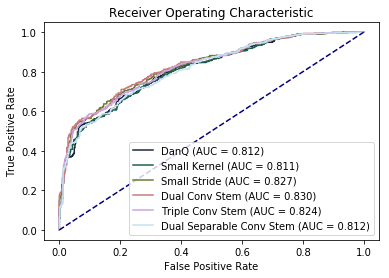

In [4]:
palette = sns.color_palette("cubehelix", len(roc_list))

#plot roc curve
for i in range(len(roc_list)):
    plt.plot(roc_list[i][0], 
             roc_list[i][1], 
             color=palette[i], 
             label='{0} (AUC = {1:.3f})'.format(label_list[i], roc_list[i][2]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('c:/users/wolf/desktop/SynPro/roc.png')
plt.show()